In [1]:
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import random
from functions import *
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from copy import deepcopy as dp
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import categorical_accuracy
from keras import backend as K 
from keras.optimizers import Adam
from keras.backend import tensorflow_backend as backend

Using TensorFlow backend.


In [2]:
def gen_model(hidden, drop, vocab_size, embed):
    model = Sequential()
    model.add(Embedding(vocab_size, 20, input_length = embed, mask_zero = True))
    model.add(LSTM(hidden))
    model.add(Dropout(drop))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    
    return model

In [42]:
def create_model(params, vocab_size, embed_size, X, y,cw = None, epoch = 6):
    
    data = list(zip(X, y))
    hate = [text for text in data if np.argmax(text[1]) == 0]
    off = [text for text in data if np.argmax(text[1]) == 1]
    nei = [text for text in data if np.argmax(text[1]) == 2]

    if cw == True:
        cw = {0:len(off)//len(hate), 1: 1, 2:len(off)//len(nei)}    

    train_set = []
    valid_set = []

    for i in [hate, off, nei]:
        random.shuffle(i)
        train_set.extend(i[round(len(i)*0.2):])
        valid_set.extend(i[:round(len(i)*0.2)])
    random.shuffle(train_set)
    X, y = zip(*train_set)
    valid_X, valid_y = zip(*valid_set)
    adam = Adam(lr=params['lr'])
    model = gen_model(params['hidden'], params['drop'], vocab_size= vocab_size, embed=embed_size) 
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[categorical_accuracy])
    history = model.fit(np.array(X), np.array(y), batch_size=params['batch'], 
                        validation_data = (np.array(valid_X), np.array(valid_y)), 
                        #validation_split = 0.2,
                        epochs=epoch, shuffle=True,
                        class_weight=cw,
                        callbacks = [es, mcp_save]#, KerasPruningCallback(trial, 'val_acc')]
                       )
    model = load_model('best_lstm.hdf5')

    return model

In [4]:
def show_result(model):
    pred = model.predict(np.array(test_X))
    prediction = np.argmax(pred, axis = 1)
    label = np.argmax(test_a, axis = 1)
    cmx = print_cmx(label, prediction)

In [5]:
m_input, w_i, i_d = load_pkl(r'C:/Users/OMAR/Documents/GitHub/zemi/cleaned_corpus/base_model_input.pkl')
test_a, train_a = load_pkl(r'C:/Users/OMAR/Documents/GitHub/zemi/cleaned_corpus/answer_data.pkl')
test_X, train_X = m_input
train_X, train_a = shuffle_data(train_X, train_a)

In [6]:
m_input2, w_i2, i_d2 = load_pkl(r'cleaned_corpus/augmented_model_input.pkl')
_, train_a2 = load_pkl(r'cleaned_corpus/augmented_ans.pkl')
_, train_X2 = m_input2
train_X2, train_a2 = shuffle_data(train_X2, train_a2)

In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, min_delta=0.005)
mcp_save = ModelCheckpoint('best_lstm.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [52]:
normal_best_params = load_pkl('tuning/tuned_parameters/lstm/lstm.pkl')
nbp = normal_best_params
normal_best_params

{'lr': 0.0052365668686423705,
 'hidden': 91,
 'drop': 0.4732293175092074,
 'batch': 18}

In [85]:
nbp['lr'] = 0.001
nbp['batch'] = 64
save_pkl('tuning/tuned_parameters/lstm/lstm.pkl', nbp)

In [54]:
lstm = create_model(nbp, len(w_i), len(train_X[0]), train_X, train_a, epoch = 4)

Train on 7488 samples, validate on 1872 samples
Epoch 1/4
7488/7488 [==============================] - 13s 2ms/step - loss: 0.8898 - categorical_accuracy: 0.5940 - val_loss: 0.6315 - val_categorical_accuracy: 0.7730
Epoch 2/4
7488/7488 [==============================] - 10s 1ms/step - loss: 0.5150 - categorical_accuracy: 0.8085 - val_loss: 0.5375 - val_categorical_accuracy: 0.7959
Epoch 3/4
7488/7488 [==============================] - 10s 1ms/step - loss: 0.3632 - categorical_accuracy: 0.8666 - val_loss: 0.4870 - val_categorical_accuracy: 0.8296
Epoch 4/4
7488/7488 [==============================] - 10s 1ms/step - loss: 0.2381 - categorical_accuracy: 0.9161 - val_loss: 0.5190 - val_categorical_accuracy: 0.8152


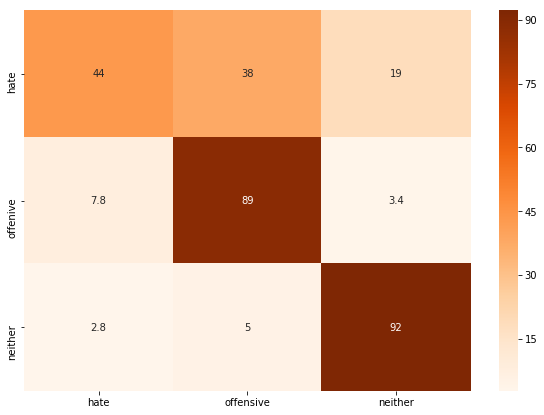

[[ 61  53  26]
 [ 39 444  17]
 [ 11  20 369]]
              precision    recall  f1-score   support

           0       0.55      0.44      0.49       140
           1       0.86      0.89      0.87       500
           2       0.90      0.92      0.91       400

   micro avg       0.84      0.84      0.84      1040
   macro avg       0.77      0.75      0.76      1040
weighted avg       0.83      0.84      0.83      1040



In [55]:
show_result(lstm)

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, min_delta=0.005)
mcp_save = ModelCheckpoint('best_lstm.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [31]:
class_weight_best_params = load_pkl('tuning/tuned_parameters/lstm/lstm_class_weight.pkl')
cbp = class_weight_best_params
class_weight_best_params

{'lr': 0.0016506045934272253,
 'hidden': 41,
 'drop': 0.3159095644935586,
 'batch': 52}

In [40]:
lstm_cw = create_model(cbp, len(w_i), len(train_X[0]), train_X, train_a, epoch = 4, cw = True)

Train on 7488 samples, validate on 1872 samples
Epoch 1/4
7488/7488 [==============================] - 10s 1ms/step - loss: 1.1238 - categorical_accuracy: 0.6851 - val_loss: 0.8690 - val_categorical_accuracy: 0.8045
Epoch 2/4
7488/7488 [==============================] - 6s 867us/step - loss: 0.6375 - categorical_accuracy: 0.8446 - val_loss: 0.6592 - val_categorical_accuracy: 0.8328
Epoch 3/4
7488/7488 [==============================] - 7s 875us/step - loss: 0.3700 - categorical_accuracy: 0.9087 - val_loss: 0.7129 - val_categorical_accuracy: 0.8178
Epoch 4/4
7488/7488 [==============================] - 6s 866us/step - loss: 0.2474 - categorical_accuracy: 0.9367 - val_loss: 0.8070 - val_categorical_accuracy: 0.8168
Epoch 00004: early stopping


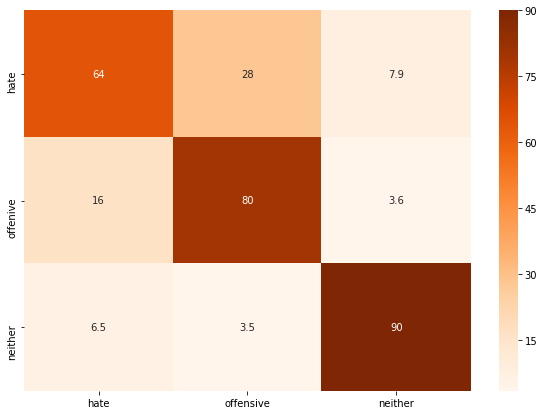

[[ 90  39  11]
 [ 82 400  18]
 [ 26  14 360]]
              precision    recall  f1-score   support

           0       0.45      0.64      0.53       140
           1       0.88      0.80      0.84       500
           2       0.93      0.90      0.91       400

   micro avg       0.82      0.82      0.82      1040
   macro avg       0.75      0.78      0.76      1040
weighted avg       0.84      0.82      0.83      1040



In [41]:
show_result(lstm_cw)

In [67]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, min_delta=0.005)
mcp_save = ModelCheckpoint('best_lstm.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [68]:
augmented_best_params = load_pkl('tuning/tuned_parameters/lstm/lstm_augmented.pkl')
abp = augmented_best_params
augmented_best_params

{'batch': 30,
 'lr': 0.013071298130398291,
 'drop': 0.6349548213958957,
 'hidden': 171}

In [77]:
lstm_aug = create_model(abp, len(w_i2), len(train_X2[0]), train_X2, train_a2, epoch = 2)

Train on 10800 samples, validate on 2700 samples
Epoch 1/2
10800/10800 [==============================] - 56s 5ms/step - loss: 0.6507 - categorical_accuracy: 0.7381 - val_loss: 0.4050 - val_categorical_accuracy: 0.8515
Epoch 2/2
10800/10800 [==============================] - 50s 5ms/step - loss: 0.3267 - categorical_accuracy: 0.8876 - val_loss: 0.3578 - val_categorical_accuracy: 0.8785


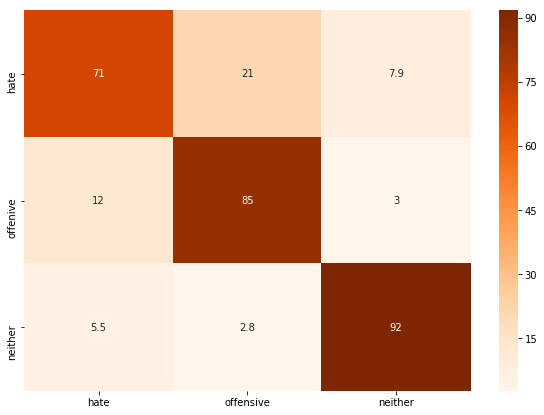

[[ 99  30  11]
 [ 61 424  15]
 [ 22  11 367]]
              precision    recall  f1-score   support

           0       0.54      0.71      0.61       140
           1       0.91      0.85      0.88       500
           2       0.93      0.92      0.93       400

   micro avg       0.86      0.86      0.86      1040
   macro avg       0.80      0.82      0.81      1040
weighted avg       0.87      0.86      0.86      1040



In [78]:
show_result(lstm_aug)

In [80]:
lstm.save('final_models/lstm.h5')

In [43]:
lstm_cw.save('final_models/lstm_class_weight.h5')

In [81]:
lstm_aug.save('final_models/lstm_augmented.h5')